# Run AR6-fair for illustrative path way scenarios from AR6.

Here we look specifically at the pathways that overshoot and we make a nice plot of the  emissions as well.
The original note book used work with @mo-gregmunday to merged the illustrative pathways from AR6 with RCMIP historical data so the data can start from 1750 and go to 2100. This processing happens in this notebook: ar6_fixer.ipynb and all the illustrative pathways are run in run-fair-ar6-illusPath and output to a csv file

In this notebook we have
    
    * Chosen 5 pathways that are specifically aimed at showing overshoot and run these through FaIR (this now appears to be working), 
    
    * Then we have made nice plots of:
        * Emissions (currently only CO2 with both fossil and afolu on one axes)
        * Temp
        * CO2 conc
        * ERF
        

In [1]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
#from climateforcing.twolayermodel import TwoLayerModel
from climateforcing.utils import check_and_download, mkdir_p
import os

In [2]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 20
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [3]:
# Download FaIR params set
check_and_download(
    'https://zenodo.org/record/5513022/files/fair-1.6.2-wg3-params.json', 
    '../data_input/fair_ar6/'
)

In [4]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [5]:
len(config_list)

2237

In [6]:
for k in config_list[0].keys():
    print (k)
    

F2x
r0
rt
rc
lambda_global
ocean_heat_capacity
ocean_heat_exchange
deep_ocean_efficacy
b_aero
ghan_params
scale
C_pi
E_pi
ghg_forcing
aCO2land
stwv_from_ch4
F_ref_BC
E_ref_BC
F_solar
F_volcanic
tropO3_forcing
b_tro3
ozone_feedback
natural


In [7]:
rt_list = []
for c in config_list:
    rt_list.append(c['natural'])
print(len(rt_list[0]))

361


In [8]:
rt_list = []
for c in config_list:
    rt_list.append(c["natural"])
print(rt_list[0][0])
print(rt_list[0][1])
print(rt_list[1][0])
print(rt_list[1][1])
len(rt_list[:])

[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]
[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]


2237

In [9]:
#scenarios = ['constant_forcing', 'constant_emissions', 'zero', 'scenario', 'infrastructure']
#scenarios = ['constant_emissions', 'zero', 'infrastructure', 'scenario']
# zero and constant emissions will be the easy ones, so start with these.

scenarios = [#'CO_Bridge', 
             'DeepElec_SSP2_ HighRE_Budg900', 
             #'EN_INDCi2030_500f', 
             'EN_NPi2020_400f_lowBECCS', 
             #'EN_NPi2020_900f',
             'SSP2_openres_lc_50',
             #'SusDev_SDP-PkBudg1000',
             #'LowEnergyDemand_1.3_IPCC' 
            ]

len(scenarios)

3

In [10]:
# Download RCMIP emissions
#check_and_download(
#    'https://zenodo.org/record/4589756/files/rcmip-emissions-annual-means-v5-1-0.csv', 
#    '../data_input/rcmip/'
#)

In [11]:
# Download illustrative pathways
#AR6Pathways = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6_data/AR6Illus_RCMIP.csv')
    #20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')


#RCMIPhist_data = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')

#plushist = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')
#plushist_long = pd.melt(plushist, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'Mip_Era', 'Activity_Id'], var_name='Year')
#rcmip_ar6 = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/IllusPathsAR6_plushistRCMIP.csv')
#rcmip_ar6_long = pd.melt(rcmip_ar6, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit'], var_name='Year')
#plushist_long.drop(columns=['Mip_Era', 'Activity_Id'], inplace=True)
#rcmip_alldata = pd.concat([plushist_long, rcmip_ar6_long])

#sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')
#g = sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')

#rcmip_alldata.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [12]:
#new = pd.DataFrame.stack(rcmip_alldata)
#new.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist_wide.csv')

#rcmip_data_wide.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [13]:
# Download illustrative pathways
#illuspd = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6/20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')

ssp_df= pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6_data/AR6Illus_RCMIP.csv')

fill_years = [str(x) for x in range(2100, 2111)]
for yr in fill_years:
    ssp_df.loc[:, yr] = ssp_df[yr].fillna(ssp_df['2100'])

years = np.arange(1750, 2111)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2111
first_row = int(first_scenyear-startyear)
#print(first_row)
last_row = int(last_scenyear-startyear)
#print(last_row)

species = [  # in fair 1.6, order is important
    '|CO2|Energy and Industrial Processes', #'MAGICC Fossil and Industrial', #1 GtC/yr
    '|CO2|AFOLU', #'MAGICC AFOLU' #2 GtC/yr
    '|CH4',   #3 Mt/yr
    '|N2O',   #4 Mt/yr
    '|Sulfur',#5 Mt/yr
    '|CO',    #6 Mt/yr
    '|VOC',   #7 Mt/yr
    '|NOx',   #8 Mt/yr
    '|BC',
    '|OC',
    '|NH3',
    '|PFC|CF4',
    '|PFC|C2F6',
    '|PFC|C6F14',
    '|HFC|HFC23',
    '|HFC|HFC32',
    '|HFC|HFC43-10', # 'HFC4310mee'
    '|HFC|HFC125',
    '|HFC|HFC134a',
    '|HFC|HFC143a',
    '|HFC|HFC227ea',
    '|HFC|HFC245ca', #'HFC245fa'
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}
# 'ssp119','ssp126','ssp245','ssp370',ssp434','ssp585''

for scenario in scenarios:
    #print(scenario)
    data_out[scenario] = np.ones((361, 40)) * np.nan
    data_out[scenario][:,0] = years
 
    for i, specie in enumerate(species):
        #print(data_out[scenario].shape,ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014'].shape)
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f =  ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2111'].dropna(axis=1)*unit_convert[i+1]
        data_out[scenario][first_row:(last_row+1), i+1] = f
        

In [14]:
#data_out['EN_INDCi2030_500f'][250:341,3]

In [15]:
#data_out['EN_INDCi2030_500f'][250:341,4]

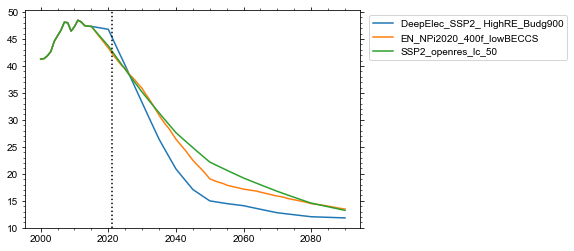

In [16]:
for scenario in scenarios:
    pl.plot(np.arange(2000, 2091), data_out[scenario][250:341,8], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Loop through the other illustrative pathways

DeepElec_SSP2_ HighRE_Budg900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:52<00:00, 42.35it/s]


EN_NPi2020_400f_lowBECCS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:52<00:00, 42.56it/s]


SSP2_openres_lc_50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:53<00:00, 42.04it/s]


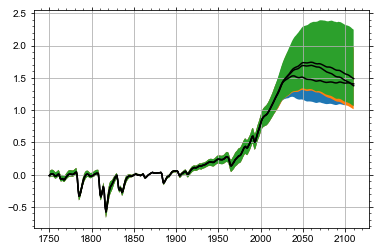

In [17]:
results_out = {}
for scenario in scenarios:
    print (scenario)
    results_out[scenario]={}
    
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[scenario]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["scale"][43] = 0.6
    
    def run_fair(args):
        thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
        return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    results_out[scenario] = {}
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    results_out[scenario]['co2_conc'] = c
    results_out[scenario]['temp'] = temp_rebase
    results_out[scenario]['F_ant'] = f_ant
    results_out[scenario]['F_aer'] = f_aer
    results_out[scenario]['F_tot'] = f_tot

    pl.fill_between(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    pl.grid()
    

# Emissions for all scenarios on the same plot!

In [18]:
colors = {#'CO_Bridge': 'green', 
          'DeepElec_SSP2_ HighRE_Budg900': 'blue', 
          #'EN_INDCi2030_500f': 'purple', 
          'EN_NPi2020_400f_lowBECCS': 'cyan', 
          #'EN_NPi2020_900f': 'orange',
          'SSP2_openres_lc_50': 'red',
          #'SusDev_SDP-PkBudg1000':'pink',
          #'LowEnergyDemand_1.3_IPCC':'cyan' 
         }
labels = {#'CO_Bridge':'CO_Bridge', 
          'DeepElec_SSP2_ HighRE_Budg900':'C1: IMP-Ren', 
          #'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
          'EN_NPi2020_400f_lowBECCS':'C2: IMP-Neg', 
          #'EN_NPi2020_900f':'EN_NPi2020_900f',
          'SSP2_openres_lc_50':'C3: IMP-Ren-2.0',
          #'SusDev_SDP-PkBudg1000':'SusDev_SDP-PkBudg1000',
          #'LowEnergyDemand_1.3_IPCC':'LowEnergyDemand_1.3_IPCC' 
           }

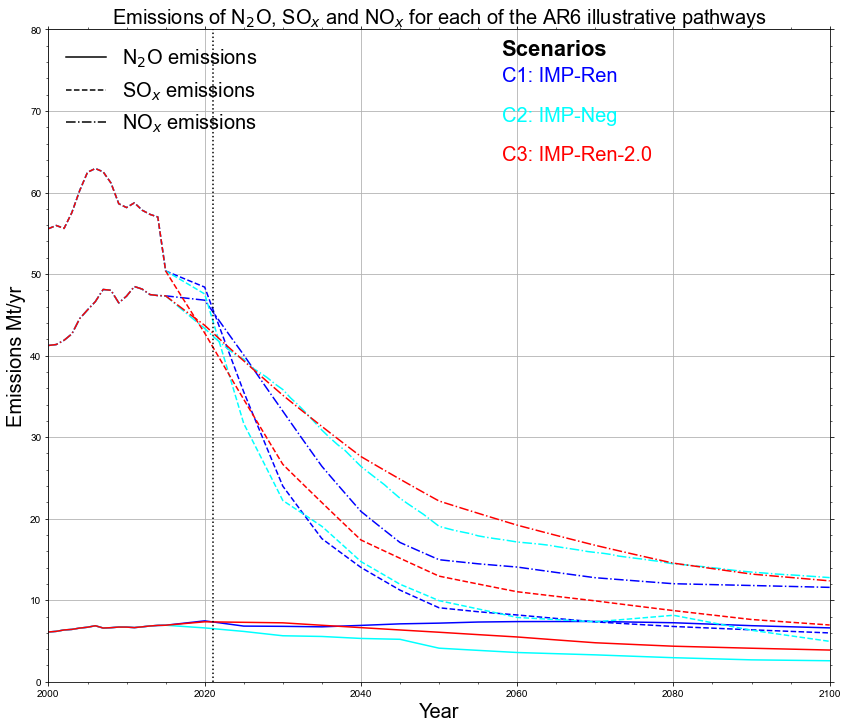

In [19]:
n2o_line = mlines.Line2D([], [], color='black', linestyle='-', label='N$_2$O emissions')
sox_line = mlines.Line2D([], [], color='black', linestyle='--', label='SO$_x$ emissions')
nox_line = mlines.Line2D([], [], color='black', linestyle='-.', label='NO$_x$ emissions')

fig, ax = pl.subplots(figsize=(14, 12))
ax.text(0.58, 0.96, 'Scenarios', fontweight='bold', fontsize=22, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,4], color=colors[scenario], label=labels[scenario])
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,5], color=colors[scenario], linestyle='--')
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,8], color=colors[scenario], linestyle='-.')
    ax.text(0.58, 0.92-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
    #ax.legend('upper right')

ax.legend(handles=[n2o_line, sox_line, nox_line], loc='upper left',  fontsize=20, frameon=False)
ax.set_ylabel('Emissions Mt/yr', fontsize='20');
ax.set_xlabel('Year', fontsize='20')
ax.set_title(r'Emissions of N$_2$O, SO$_x$ and NO$_x$ for each of the AR6 illustrative pathways',fontsize=20);
ax.set_xlim(2000, 2100)
ax.set_ylim(0,80)
pl.axvline(2021, ls=':', color='k')
pl.grid()
pl.savefig('../plots/overshoot_illusPathways_scenarios_emissions_others.png', dpi=500, transparent=False)

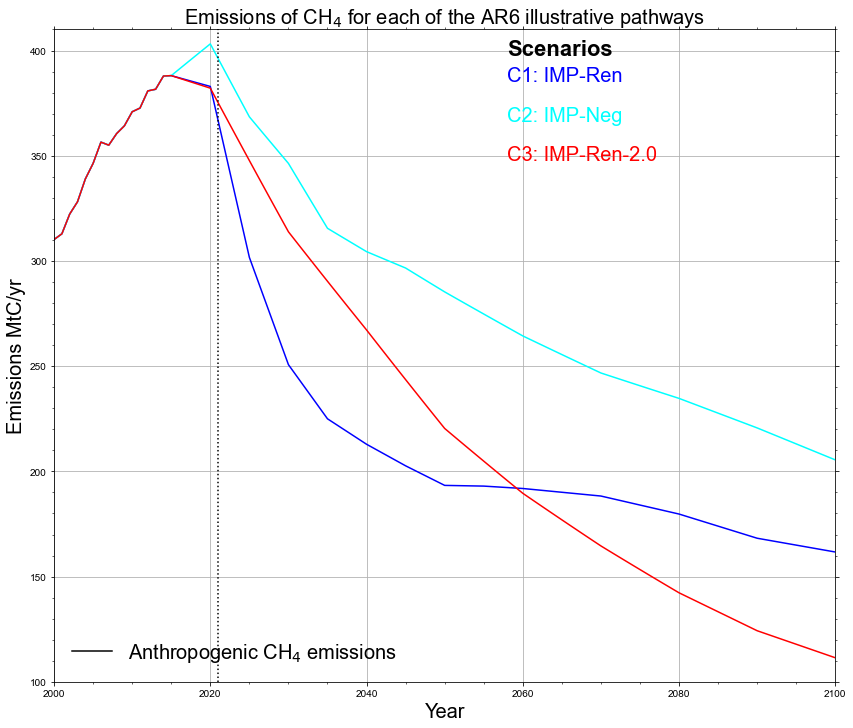

In [20]:
CH4_line = mlines.Line2D([], [], color='black', linestyle='-', label='Anthropogenic CH$_4$ emissions')
fig, ax = pl.subplots(figsize=(14, 12))
ax.text(0.58, 0.96, 'Scenarios', fontweight='bold', fontsize=22, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,3], color=colors[scenario], label=labels[scenario])
    #ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,2], color=colors[scenario], linestyle='--')
    ax.text(0.58, 0.92-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
    #ax.legend('upper right')

ax.legend(handles=[CH4_line], loc='lower left',  fontsize=20, frameon=False)
ax.set_ylabel('Emissions MtC/yr', fontsize='20');
ax.set_xlabel('Year', fontsize='20')
ax.set_title(r'Emissions of CH$_4$ for each of the AR6 illustrative pathways',fontsize=20);
ax.set_xlim(2000, 2100)
ax.set_ylim(100,410)
pl.axvline(2021, ls=':', color='k')
pl.grid()
pl.savefig('../plots/overshoot_illusPathways_scenarios_emissions_CH4.png', dpi=500, transparent=False)

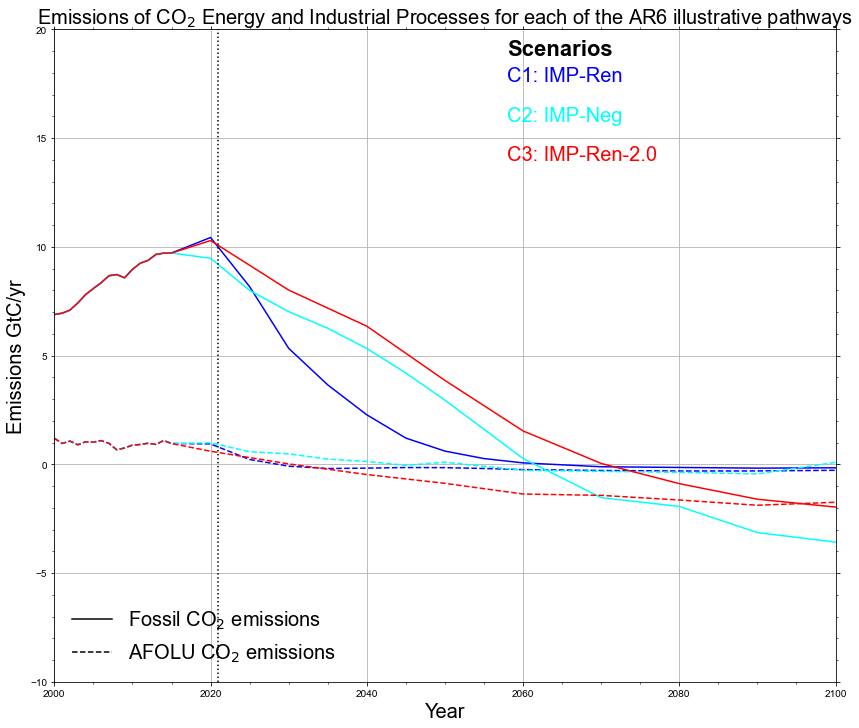

In [21]:
fossil_line = mlines.Line2D([], [], color='black', linestyle='-', label='Fossil CO$_2$ emissions')
afolu_line = mlines.Line2D([], [], color='black', linestyle='--', label='AFOLU CO$_2$ emissions')

fig, ax = pl.subplots(figsize=(14, 12))
ax.text(0.58, 0.96, 'Scenarios', fontweight='bold', fontsize=22, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,1], color=colors[scenario], label=labels[scenario])
    ax.plot(np.arange(2000, 2101), data_out[scenario][250:351,2], color=colors[scenario], linestyle='--')
    ax.text(0.58, 0.92-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
    #ax.legend('upper right')

ax.legend(handles=[fossil_line, afolu_line], loc='lower left',  fontsize=20, frameon=False)
ax.set_ylabel('Emissions GtC/yr', fontsize='20');
ax.set_xlabel('Year', fontsize='20')
ax.set_title(r'Emissions of CO$_2$ Energy and Industrial Processes for each of the AR6 illustrative pathways',fontsize=20);
ax.set_xlim(2000, 2100)
ax.set_ylim(-10,20)
pl.axvline(2021, ls=':', color='k')
pl.grid()
pl.savefig('../plots/overshoot_illusPathways_scenarios_emissions_CO2.png', dpi=500, transparent=False)

In [47]:
#  Year FossilCO2  OtherCO2       CH4       N2O       NOx     NMVOC        CO       SOx       SOx       SOx       CF4      C2F6    HFC125   HFC134a   HFC143a  HFC227ea  HFC245fa       SF6
#          GtC/yr    GtC/yr  MtCH4/yrMtN2O-N/yr    MtN/yr     Mt/yr   MtCO/yr    MtS/yr    MtS/yr    MtS/yr     kt/yr     kt/yr     kt/yr     kt/yr     kt/yr     kt/yr     kt/yr     kt/yr
   #co2,co2,ch4,n2o,nox,nmvoc,co,sox,sox,sox,cf4,c2f6,hfc125,hfc134a,hfc143a,hfc227ea,hfc245fa,sf6
d =dict()
conv = [1,1,28,265,1,1,1,1,1,1,6630,11100,3170,1300,4800,3350,858,23500] #AR5 100 yr GWPs for converting to CO2e
conv1 = 44./12.
#dat_co2e=data_out.copy()

for scenario in scenarios:
    print (data_out[scenario].shape,)
    dat_co2e=data_out[scenario][:361].copy()
    dat_co2e[:,1] = data_out[scenario][:361,1]*1e3*3.67
    dat_co2e [:,3] = data_out[scenario][:361,3]*conv[2]
    dat_co2e [:,4] = data_out[scenario][:361,4]*conv[3]*(44./28.) 
    dat_co2e [:,11] = data_out[scenario][:361,11]*conv[10]*1e-3
    dat_co2e [:,12] = data_out[scenario][:361,12]*conv[11]*1e-3
    dat_co2e [:,13] = data_out[scenario][:361,13]*conv[12]*1e-3
    dat_co2e [:,14] = data_out[scenario][:361,14]*conv[13]*1e-3
    dat_co2e [:,15] = data_out[scenario][:361,15]*conv[14]*1e-3
    dat_co2e [:,16] = data_out[scenario][:361,16]*conv[15]*1e-3
    dat_co2e [:,17] = data_out[scenario][:361,17]*conv[16]*1e-3
    dat_co2e [:,18] = data_out[scenario][:361,18]*conv[17]*1e-3
    dat_co2e [:,5] = 0.0
    dat_co2e [:,6] = 0.0
    dat_co2e [:,7] = 0.0
    dat_co2e [:,8] = 0.0
    
    
    totghg = np.sum(dat_co2e[:,1:],axis=1)# total co2e
    edx = np.where(data_out[scenario][:,0]==2020)[0][0]
    d  = totghg[edx]*1e-3 # Convert values back into GtCO2e here
    
    print(scenario, d, edx, dat_co2e)


(361, 40)
DeepElec_SSP2_ HighRE_Budg900 62.463963512276926 270 [[ 1.75000000e+03  9.51426136e+00  8.11267109e-02 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 1.75100000e+03  9.51460501e+00  8.26192087e-02 ...  0.00000000e+00
   1.05107200e+02  4.27676850e+03]
 [ 1.75200000e+03  9.51864750e+00  8.41391642e-02 ...  0.00000000e+00
   1.05125020e+02  4.27770490e+03]
 ...
 [ 2.10800000e+03 -5.78832634e+02 -2.73581297e-01 ...  8.10000000e-03
   1.05263400e+02  4.37179310e+03]
 [ 2.10900000e+03 -5.78832634e+02 -2.73581297e-01 ...  8.10000000e-03
   1.05263400e+02  4.37179310e+03]
 [ 2.11000000e+03 -5.78832634e+02 -2.73581297e-01 ...  8.10000000e-03
   1.05263400e+02  4.37179310e+03]]
(361, 40)
EN_NPi2020_400f_lowBECCS 59.55255228348234 270 [[ 1.75000000e+03  9.51426136e+00  8.11267109e-02 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 1.75100000e+03  9.51460501e+00  8.26192087e-02 ...  0.00000000e+00
   1.05107200e+02  4.27676850e+03]
 [ 1.75200000e+03  9.51864750e+00 

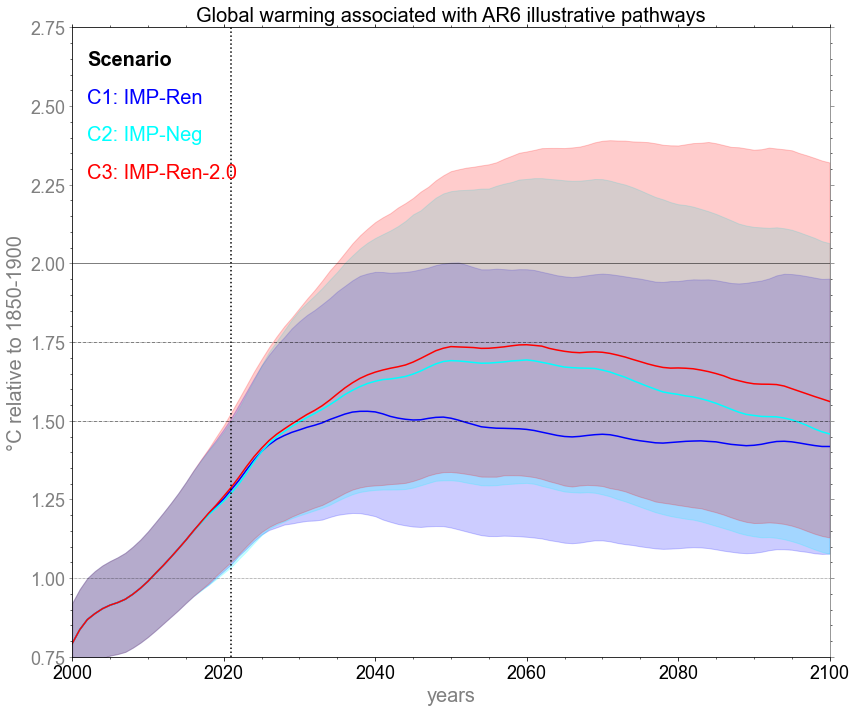

In [29]:
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
#scenarios = ['ssp119',  'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp585']

fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=20, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), 
                    np.percentile(results_out[scenario]['temp'][250:351,:] , 5, axis=1), 
                    np.percentile(results_out[scenario]['temp'][250:351,:] , 95, axis=1), 
                    color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] , axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
#ax.legend(fontsize=10);
ax.set_title('Global warming associated with AR6 illustrative pathways', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
positions = np.arange(0.75, 2.76, 0.25)
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax.set_ylim(0.75,2.75)
ax.spines['right'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.set_ylabel('°C relative to 1850-1900', color='gray',fontsize=20)
ax.set_xlabel('years', color='gray',fontsize=20)
pl.axvline(2021, ls=':', color='k')

ax.axhline(1, ls=':', color='k', lw=0.5)
ax.axhline(1.5, ls='-.', color='k', lw=0.5)
ax.axhline(1.75, ls='-.', color='k', lw=0.5)
ax.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/overshoot_illusPathways_scenarios_temp.png', dpi=500, transparent=False)

# All on the same plot CO2 conc!

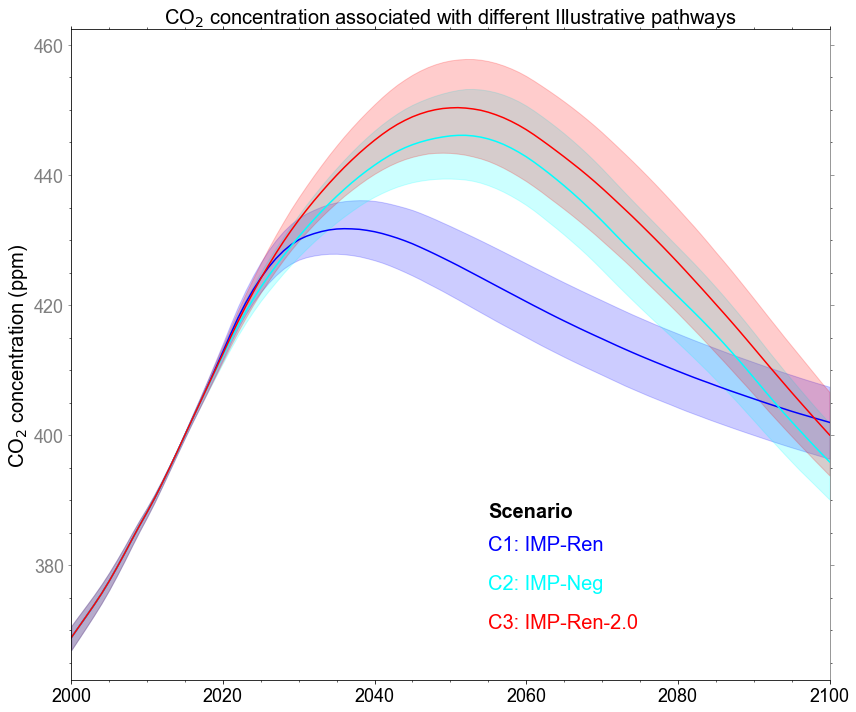

In [30]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.55, 0.25, 'Scenario', fontweight='bold', fontsize=20, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), 
                    np.percentile(results_out[scenario]['co2_conc'][250:351,:] , 5, axis=1), 
                    np.percentile(results_out[scenario]['co2_conc'][250:351,:] , 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['co2_conc'][250:351,:] , axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.55, 0.2-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)', fontsize=20);
ax.set_title(r'CO${_2}$ concentration associated with different Illustrative pathways', fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


#ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.spines['right'].set_color('gray')
ax.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/overshoot_illusPathways_scenarios_CO2conc.png', dpi=500, transparent=False)

# All on the same plot ERF!

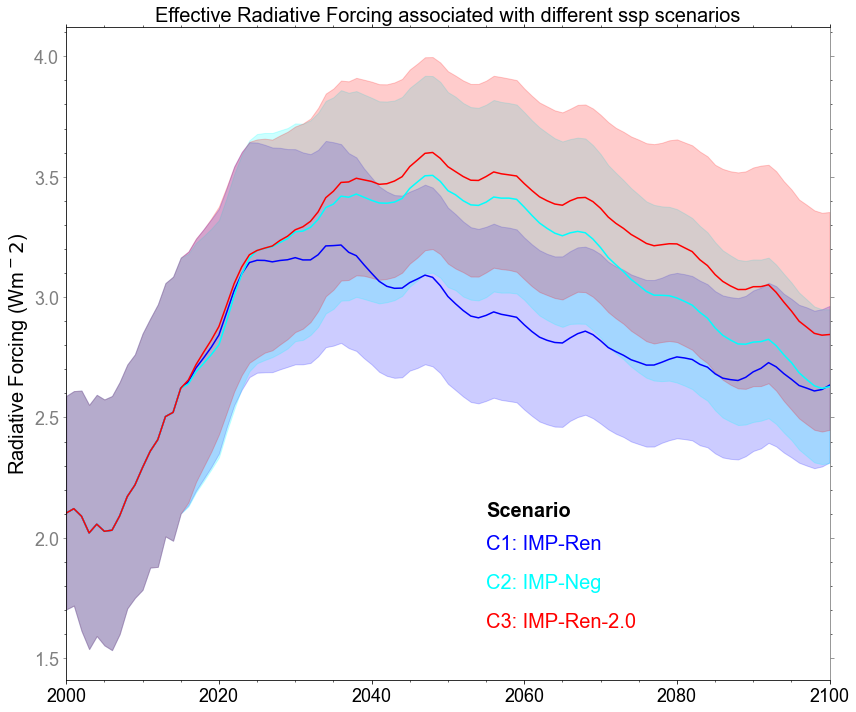

In [31]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.55, 0.25, 'Scenario', fontweight='bold', fontsize=20, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), 
                    np.percentile(results_out[scenario]['F_tot'][250:351,:], 5, axis=1), 
                    np.percentile(results_out[scenario]['F_tot'][250:351,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['F_tot'][250:351,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.55, 0.2-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=20)
#ax.legend(fontsize=10);
ax.set_ylabel(r'Radiative Forcing (Wm${^-2}$)',fontsize=20);
ax.set_title('Effective Radiative Forcing associated with different ssp scenarios',fontsize=20);
ax.set_xlim(2000, 2100)
#ax.set_ylim(0, 4)

from matplotlib import ticker
#ax.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax.spines['right'].set_color('gray')
ax.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/overshoot_illusPathways_scenarios_erf.png', dpi=500, transparent=False)

In [26]:
np.percentile(results_out[scenario]['F_tot'][250:351,:], 5, axis=1)

array([1.70266529, 1.71857984, 1.61363005, 1.5377991 , 1.59210453,
       1.55334194, 1.53353153, 1.6001565 , 1.7068034 , 1.75053933,
       1.78396636, 1.87629661, 1.87952633, 2.00586378, 1.98791388,
       2.10106493, 2.14728887, 2.23171936, 2.29489285, 2.35747581,
       2.42897193, 2.5173062 , 2.60727488, 2.67629598, 2.72757212,
       2.74889445, 2.76906954, 2.77903335, 2.80302663, 2.82547062,
       2.85472489, 2.86868677, 2.8960623 , 2.94180404, 3.00350228,
       3.03044848, 3.06863763, 3.07119344, 3.09041153, 3.08845574,
       3.0802111 , 3.0716272 , 3.07565507, 3.08359694, 3.10151331,
       3.13914649, 3.16435287, 3.19474693, 3.19950466, 3.17854287,
       3.13937734, 3.11861419, 3.10346362, 3.08535843, 3.08517471,
       3.1025233 , 3.12208639, 3.11633135, 3.11281247, 3.10506455,
       3.07448476, 3.0451734 , 3.02129784, 3.00848231, 2.99613936,
       2.99018041, 3.00661567, 3.02221567, 3.02068721, 3.00139317,
       2.97222485, 2.93744218, 2.9116948 , 2.88914024, 2.85996

In [27]:
np.percentile(results_out[scenario]['F_tot'][250:351,:], 95, axis=1)

array([2.58945123, 2.6095473 , 2.61182773, 2.55233841, 2.59405905,
       2.57489131, 2.58921072, 2.6470783 , 2.71982892, 2.76223526,
       2.84858267, 2.91055703, 2.96954967, 3.05826169, 3.08480143,
       3.16387316, 3.18923969, 3.2435441 , 3.28157199, 3.32653369,
       3.37585644, 3.45657614, 3.54154112, 3.60189223, 3.64506602,
       3.65497466, 3.65801927, 3.65430464, 3.67135427, 3.68685083,
       3.70867043, 3.72092774, 3.7417609 , 3.78584112, 3.84523232,
       3.86626354, 3.89934902, 3.89618832, 3.91071783, 3.90298892,
       3.89490563, 3.88437937, 3.88381896, 3.89171326, 3.9062439 ,
       3.94519453, 3.96961474, 3.99626466, 3.997043  , 3.97447448,
       3.93829435, 3.9197895 , 3.89962874, 3.88529163, 3.88544224,
       3.8988341 , 3.9192606 , 3.9139515 , 3.90786148, 3.90135364,
       3.86660581, 3.83610797, 3.80820494, 3.79197298, 3.77555841,
       3.7672555 , 3.78203555, 3.79835295, 3.80010382, 3.78339868,
       3.75728407, 3.72689938, 3.70311771, 3.68659725, 3.66704